In [1]:
import os, numpy as np, librosa, laion_clap, torch, umap
root='../webcache'
paths = [os.path.join(dp,f) for dp,_,fs in os.walk(root) for f in fs if f.lower().endswith((".wav",".flac",".mp3",".aiff",".aif",".ogg"))]
print(len(paths),'files')

6531 files


In [2]:
# paths = paths[:10]

In [3]:
model = laion_clap.CLAP_Module(enable_fusion=False, amodel='HTSAT-base')
model.load_ckpt("../webcache/music_audioset_epoch_15_esc_90.14.pt")  # downloaded from HF

/Users/alexe/dev/ginkgo/.venv/lib/python3.13/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4319.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load the specified checkpoint ../webcache/music_audioset_epoch_15_esc_90.14.pt from users.
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.bias 	 Loaded
audio_branch.layers.0.bl

In [ ]:
from tqdm import tqdm
batches=[]
for i in tqdm(range(0, len(paths), 100)):
    batch = model.get_audio_embedding_from_filelist(x=paths[i:i+100], use_tensor=False)
    batches.append(batch)
E_clap = np.vstack(batches)
Z = E_clap


100%|██████████| 66/66 [08:48<00:00,  8.01s/it]


In [ ]:
def tiny_feats(p):
    y, sr = librosa.load(p, sr=48000, mono=True)
    C = librosa.feature.chroma_cqt(y=y, sr=sr).mean(1)                  # 12
    on = librosa.onset.onset_strength(y=y, sr=sr); trans = [on.mean(), on.std()]  # 2
    spec = librosa.feature.spectral_centroid(y=y, sr=sr).mean()         # 1
    return np.r_[C, trans, spec]                                        # 15D
# tiny features...
F = np.vstack([tiny_feats(p) for p in tqdm(paths)])


  0%|          | 9/6531 [00:00<04:32, 23.95it/s]/Users/alexe/dev/ginkgo/.venv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=586
  warnings.warn(
/Users/alexe/dev/ginkgo/.venv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=293
  warnings.warn(
/Users/alexe/dev/ginkgo/.venv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=147
  warnings.warn(
/Users/alexe/dev/ginkgo/.venv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=74
  warnings.warn(
/Users/alexe/dev/ginkgo/.venv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=37
  warnings.warn(
/Users/alexe/dev/ginkgo/.venv/lib/python3.13/site-packages/librosa/core/spectrum.py:

In [44]:
Z = np.hstack([E_clap, F])
Z=Z-Z.mean(0)
Z=Z/Z.std(0)

In [77]:
use_tsne = True
if use_tsne:
    from sklearn.manifold import TSNE
    Z_map = TSNE(n_components=2, perplexity=50, metric="cosine", init="pca").fit_transform(Z)
else:
    Z_map = umap.UMAP(n_neighbors=250, min_dist=0.1, metric="cosine").fit_transform(Z)


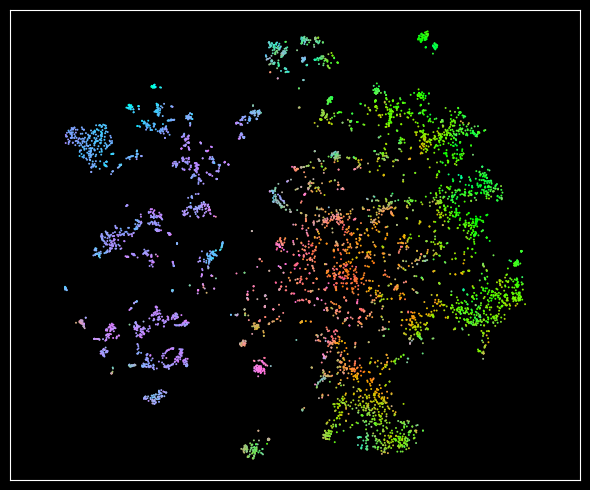

In [78]:
import numpy as np, matplotlib.pyplot as plt

def svd_cbcr_colors(Z, Y=0.5, robust=False):
    U, S, Vt = np.linalg.svd(Z, full_matrices=False)
    X = U[:, :2] * S[:2]                             # principal scores on top-2
    if robust:
        lo, hi = np.percentile(X, [1, 99], axis=0)
        X = np.clip(X, lo, hi)
    C = (X - X.min(0)) / (X.ptp(0) + 1e-12)          # scale each to [0,1]
    Cb, Cr = C[:,0], C[:,1]

    # YCbCr (BT.601 full-range-ish) -> RGB
    cb, cr = Cb - 0.5, Cr - 0.5
    R = Y + 1.402 * cr
    G = Y - 0.344136 * cb - 0.714136 * cr
    B = Y + 1.772 * cb
    RGB = np.clip(np.c_[R,G,B], 0, 1)
    return RGB

RGB = svd_cbcr_colors(Z, Y=0.7, robust=True)        # set robust=False if you prefer raw min-max

plt.figure(figsize=(6,5))
plt.style.use('dark_background')

plt.scatter(Z_map[:,0], Z_map[:,1], c=RGB, s=2, linewidths=0)
plt.axis('equal'); plt.xticks([]); plt.yticks([]); plt.tight_layout()


In [85]:
from scipy.spatial.distance import cdist
dists = cdist(Z_map, Z_map, metric='euclidean')
np.fill_diagonal(dists, np.inf)  # Ignore self-distance
mindist = np.min(dists, axis=1)
print(mindist[0])


0.1832057784713055


In [86]:
j = {paths[i].replace(root+'/', '') : Z_map[i].tolist() + RGB[i].tolist() + [mindist[i]] for i in range(len(paths))}
import json
with open(root+'/umap_sounds.json', 'w') as f:
    json.dump(j, f, indent=2)
